In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as lin
from cs771 import plotData as pd, utils, genSyntheticData as gsd
from sklearn.svm import LinearSVC as csvm
import random
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

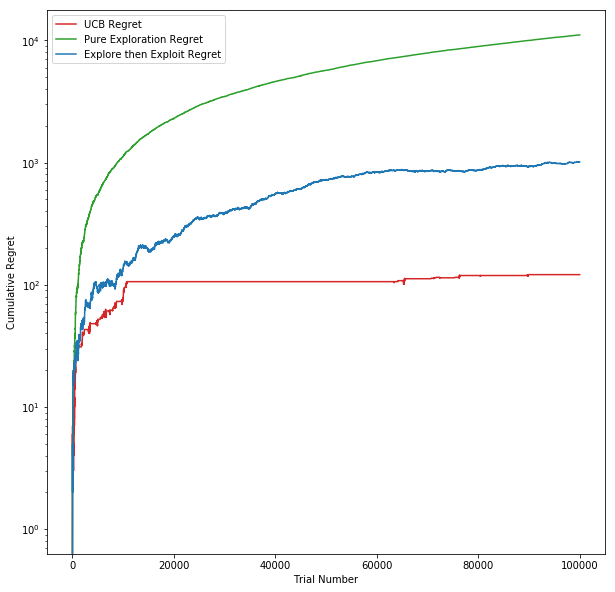

In [3]:
def armSimulator( probs, T ):
    k = len( probs ) # Number of arms
    rewards = np.zeros( ( T, k ) )
    for i in range( k ):
        rewards[:,i] = np.random.binomial( 1, probs[i], T )
    return rewards

def doOracle( rewards, aBest ):
    bestArmRewards = rewards[:,aBest].reshape(-1)
    return np.cumsum(bestArmRewards)

# The Upper Confidence Bound algorithm
def doUCB( rewards ):
    (T, k) = rewards.shape
    rinstantaneous = np.zeros( (T,) )
    rhat = np.zeros( (k,) )
    nhat = np.ones( (k,) )
    for t in range( T ):
        arm = np.argmax( rhat/nhat + 1/np.sqrt( nhat ) )
        nhat[arm] += 1
        rhat[arm] += rewards[ t, arm ]
        rinstantaneous[t] = rewards[ t, arm ]
    return np.cumsum( rinstantaneous )

# The Pure Exploration algorithm
def doPE( rewards ):
    (T, k) = rewards.shape
    rinstantaneous = np.zeros( (T,) )
    # Just cycle over the arms and sample all of them in turn
    for t in range( T ):
        arm = t % k
        rinstantaneous[t] = rewards[ t, arm ]
    return np.cumsum( rinstantaneous )

# The Explore-then-exploit algorithm
def doETE( rewards ):
    (T, k) = rewards.shape
    rinstantaneous = np.zeros( (T,) )
    rhat = np.zeros( (k,) )
    nhat = np.ones( (k,) )
    # For the first several trials just explore purely to find the best arm
    # We will then play the best arm for the rest of the trials. We will see
    # that if TExplore is small, we end up identifying a bad arm as the best
    # arm and stick to it for the rest of the trials. If TExplore is large
    # then we waste a lot of time exploring which anyway forces large regret
    TExplore = int( np.sqrt( T ) )
    for t in np.arange( TExplore ):
        arm = t % k
        nhat[arm] += 1
        rhat[arm] += rewards[ t, arm ]
        rinstantaneous[t] = rewards[ t, arm ]
    
    # Choose the arm that looks the best at the end of this exploration period
    armSel = np.argmax( rhat/nhat )
    rinstantaneous[TExplore:] = rewards[ TExplore:, armSel ]
    return np.cumsum( rinstantaneous )

def MABtrials( p, n, aBest ):
    rewards = armSimulator( p, n )
    # The oracle knows the best arm and simply pulls it again and again
    cumRewardsOracle = doOracle( rewards, aBest )
    # The UCB algo implements optimism in the face of uncertainty
    cumRewardsUCB = doUCB( rewards )
    # This algorithm simply explores each arm uniformly often
    cumRewardsPureExplore = doPE( rewards )
    # This algorithm explores purely for a few steps and then exploits
    # the arm that it finds to be best at the end of the exploration period
    cumRewardsExploreThenExploit = doETE( rewards )
    fig = pd.getFigure( 10, 10 )
    ax = plt.gca()
    # The notion of "regret" measures how much reward did an algorithm miss receiving
    # which it could have received had that algorithm correctly identified the best arm.
    # The UCB algorithm theoretically guarantees a regret bound of \sqrt{k * T} where 
    # k is the number of arms and T is the number of trials. The other algorithms e.g.
    # pure exploration or explore-then-exploit all suffer linear regret i.e. \Omega(T).
    ax.semilogy( np.arange( n ), cumRewardsOracle - cumRewardsUCB, color = "tab:red", label = "UCB Regret" )
    ax.semilogy( np.arange( n ), cumRewardsOracle - cumRewardsPureExplore, color = "tab:green", label = "Pure Exploration Regret" )
    ax.semilogy( np.arange( n ), cumRewardsOracle - cumRewardsExploreThenExploit, color = "tab:blue", label = "Explore then Exploit Regret" )
    ax.set_xlabel( "Trial Number" )
    ax.set_ylabel( "Cumulative Regret" )
    plt.legend()

k = 10
# There are k arms some of which are very close to the best arm
p = 1.0 - 1/np.arange( 2, k + 2 )[np.random.permutation( k )]
aBest = np.argmax( p )
n = 100000
# Notice that UCB offers regret that is a couple of orders of magnitude smaller
# than the regret offered by pure exploration or explore-then-exploit strategies
# Notice that the y-axis is in logscale in the plot
MABtrials( p, n, aBest )